In [1]:
import sys
import os
sys.path.append(os.path.abspath(".."))

from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt
import numpy as np
import jax
import jax.numpy as jnp
import jax.random as jr
from gpkan.gpKAN import GPKAN
import scienceplots

from matplotlib.cm import ScalarMappable
plt.style.use([ 'science', "grid"])

/Users/aaron/Documents/masters/gaussian-process-kan/.venv/lib/python3.12/site-packages/cola/backends/backends.py:75: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(cls, tree_flatten, tree_unflatten)


## Data setup

In [2]:
def himmelblau(x, y):
    assert jnp.all((-5 <= x) & (x <= 5)) and jnp.all((-5 <= y) & (y <= 5)), (
        "x and y must be in the range [-5, 5]"
    )
    return (x**2 + y - 11) ** 2 + (x + y**2 - 7) ** 2

In [3]:
f = lambda x, y: himmelblau(x, y) 
# 
samples = 40
x1, x2 = jnp.meshgrid(jnp.linspace(-5, 5, samples), jnp.linspace(-5 , 5, samples))
X = jnp.stack([x1.flatten(), x2.flatten()]).T
# y = jnp.log(f(X[:, 0], X[:, 1])).reshape(-1, 1)
y = f(X[:, 0], X[:, 1]).reshape(-1, 1)
print(min(y), max(y))
y = jnp.sqrt(f(X[:, 0], X[:, 1]).reshape(-1, 1))
print(min(y), max(y))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

[0.27056234] [890.]
[0.52015607] [29.83286778]


## Models

### MLP

In [ ]:
model = Sequential([
    Dense(5, activation='relu', input_shape=(2,)),
    # Dense(10, activation='relu', input_shape=(2,)),
    # Dense(5, activation='relu'),
    Dense(1, activation='linear')
])

# model.summary()
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
history = model.fit(X_train, y_train, epochs=1000, batch_size=32, validation_split=0.2, verbose=1)
y_pred_mlp = model.predict(X)

NameError: name 'Sequential' is not defined

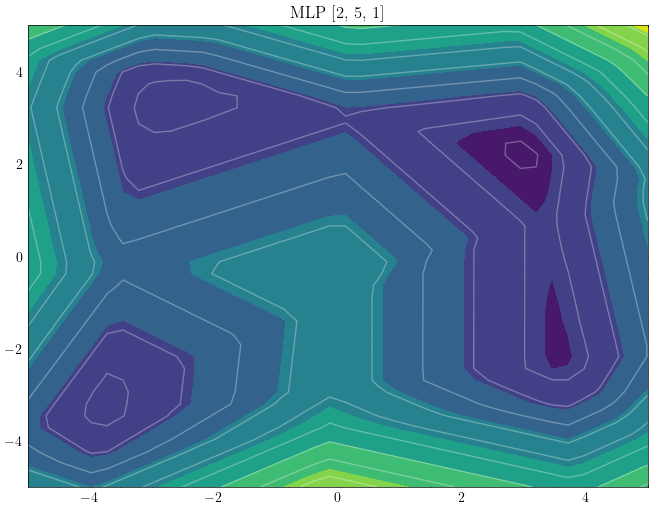

In [5]:
plt.figure(figsize=(8, 6))
plt.contourf(x1, x2, y_pred_mlp.reshape(samples, samples))
plt.contour(x1, x2, y_pred_mlp.reshape(samples, samples), levels=10, colors="white", alpha=.3)
plt.title("MLP [2, 5, 1]")
plt.show()

### KAN+GP

In [6]:
model_size = [2, 5, 1]
model = GPKAN(layers=model_size,
              n_grid_points=10, 
              grid_min=jnp.min(X), 
              grid_max=jnp.max(X), 
              init_paramters=[1.0, 1.0], 
              obs_stddev=0.5
              )

Model initialized.


In [7]:
# Helper functions
def loss_ll(y_true, mean, covariance):
    diag_elements = jnp.diag(covariance)
    covariance_inv = jnp.diag(1.0 / diag_elements)
    log_det = jnp.sum(jnp.log(diag_elements))
    y_true = y_true.flatten()

    return -(-0.5 * (
        y_true.shape[0] * jnp.log(2 * jnp.pi) + 
        log_det + 
        (y_true - mean).T @ covariance_inv @ (y_true - mean)))

def get_learning_rate(epoch, initial_lr=0.0001):
    return initial_lr * (0.95 ** (epoch//50))
get_learning_rate = jax.jit(get_learning_rate)

def clip_gradients(grads, max_norm=1.0):
    grad_norm = jnp.sqrt(sum(jnp.sum(g**2) for g in jax.tree.leaves(grads)))
    clip_factor = jnp.minimum(1.0, max_norm / grad_norm)
    return jax.tree.map(lambda g: g * clip_factor, grads)
clip_gradients = jax.jit(clip_gradients)

val_grad_loss = jax.value_and_grad(
    lambda Xs_latent, ys_latent, kernel_params, X_test, y_test:
        loss_ll(y_test,
                *model.sample_statistics(Xs_latent, ys_latent, X_test, kernel_params, n_samples=10)
                ),
                argnums=(0, 1, 2)
)
val_grad_loss = jax.jit(val_grad_loss)

In [8]:
epochs = 500
learning_rate = 0.001
loss_history = []

batch_size = 32
patience = 100  # Number of epochs to wait for improvement
best_loss = float('inf')
patience_counter = 0

for epoch in range(epochs):
    epoch_losses = []
    current_lr = get_learning_rate(epoch, initial_lr=learning_rate)

    for i in range(0, X_train.shape[0], batch_size):
        batch_X = X_train[i:i+batch_size, :]
        batch_y = y_train[i:i+batch_size, :]

        loss, (grad_grids, grad_supports, grad_params) = val_grad_loss(
            model.latent_grids, 
            model.latent_supports,
            model.kernel_parameters,
            batch_X, batch_y
            )
        
        # Stop training if loss becomes negative
        if loss < 0 or jnp.isnan(loss):
            print(f"Stopping training at epoch {epoch} as loss became negative: {loss}")
            break 

        # grad_supports = clip_gradients(grad_supports)

        model.latent_supports = jax.tree.map(
            lambda latent_supports, grad_supports_: 
            latent_supports - grad_supports_ * current_lr,
            model.latent_supports,
            grad_supports
        )
        model.latent_grids = jax.tree.map(
            lambda latent_grids, grad_grids_: 
            latent_grids - grad_grids_ * current_lr,
            model.latent_grids,
            grad_grids
        )

        epoch_losses.append(loss)

    # Check for improvement
    epoch_loss = np.mean(epoch_losses)
    if loss < best_loss:
        best_loss = loss
        patience_counter = 0 
    else:
        patience_counter += 1
    if patience_counter >= patience:
        print(f"Early stopping at epoch {epoch}, best loss: {best_loss}")
        break

    loss_history.append(epoch_loss)

    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Loss: {epoch_loss:.6f}, LR: {current_lr:.6f}")
    loss_history.append(loss)

/Users/aaron/Documents/masters/gaussian-process-kan/.venv/lib/python3.12/site-packages/cola/backends/backends.py:75: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(cls, tree_flatten, tree_unflatten)
/Users/aaron/Documents/masters/gaussian-process-kan/.venv/lib/python3.12/site-packages/cola/backends/backends.py:75: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(cls, tree_flatten, tree_unflatten)


Epoch 0: Loss: 433.988583, LR: 0.001000
Epoch 10: Loss: 96.531351, LR: 0.001000
Epoch 20: Loss: 89.209986, LR: 0.001000
Epoch 30: Loss: 86.243544, LR: 0.001000
Epoch 40: Loss: 84.281701, LR: 0.001000
Epoch 50: Loss: 82.536291, LR: 0.000950
Epoch 60: Loss: 80.853398, LR: 0.000950
Epoch 70: Loss: 79.195355, LR: 0.000950
Epoch 80: Loss: 77.677180, LR: 0.000950
Epoch 90: Loss: 76.282676, LR: 0.000950
Epoch 100: Loss: 75.014095, LR: 0.000902
Epoch 110: Loss: 73.930833, LR: 0.000902
Epoch 120: Loss: 72.955597, LR: 0.000902
Epoch 130: Loss: 72.069344, LR: 0.000902
Epoch 140: Loss: 71.258581, LR: 0.000902
Epoch 150: Loss: 70.515755, LR: 0.000857
Epoch 160: Loss: 69.866383, LR: 0.000857
Epoch 170: Loss: 69.266978, LR: 0.000857
Epoch 180: Loss: 68.712747, LR: 0.000857
Epoch 190: Loss: 68.199936, LR: 0.000857
Epoch 200: Loss: 67.725416, LR: 0.000815
Epoch 210: Loss: 67.307586, LR: 0.000815
Epoch 220: Loss: 66.919057, LR: 0.000815
Epoch 230: Loss: 66.556817, LR: 0.000815
Epoch 240: Loss: 66.217884

In [9]:
# learning_rate = 0.01
loss_history_params = []

batch_size = 32
patience = 100  # Number of epochs to wait for improvement
best_loss = float('inf')
patience_counter = 0

for epoch in range(epochs):
    epoch_losses_params = []
    current_lr = get_learning_rate(epoch, initial_lr=learning_rate)

    for i in range(0, X_train.shape[0], batch_size):
        batch_X = X_train[i:i+batch_size, :]
        batch_y = y_train[i:i+batch_size, :]

        loss, (grad_grids, grad_supports, grad_params) = val_grad_loss(
            model.latent_grids, 
            model.latent_supports,
            model.kernel_parameters,
            batch_X, batch_y
            )
        
        # Stop training if loss becomes negative
        if loss < 0 or jnp.isnan(loss):
            print(f"Stopping training at epoch {epoch} as loss became negative: {loss}")
            break 

        grad_params = clip_gradients(grad_params)

        model.kernel_parameters = jax.tree.map(
            lambda kernel_params, grad_params_:
            kernel_params - grad_params_ * current_lr,
            model.kernel_parameters,
            grad_params 
        )

        epoch_losses_params.append(loss)

    # Check for improvement
    epoch_loss_params = np.mean(epoch_losses_params)
    if loss < best_loss:
        best_loss = loss
        patience_counter = 0 
    else:
        patience_counter += 1
    if patience_counter >= patience:
        print(f"Early stopping at epoch {epoch}, best loss: {best_loss}")
        break

    loss_history_params.append(epoch_loss_params)

    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Loss: {epoch_loss_params:.6f}, LR: {current_lr:.6f}")
    loss_history.append(loss)

Epoch 0: Loss: 61.249516, LR: 0.001000
Epoch 10: Loss: 58.600376, LR: 0.001000
Epoch 20: Loss: 57.197404, LR: 0.001000
Epoch 30: Loss: 56.318730, LR: 0.001000
Epoch 40: Loss: 55.694452, LR: 0.001000
Epoch 50: Loss: 55.213312, LR: 0.000950
Epoch 60: Loss: 54.833107, LR: 0.000950
Epoch 70: Loss: 54.496646, LR: 0.000950
Epoch 80: Loss: 54.184316, LR: 0.000950
Epoch 90: Loss: 53.884745, LR: 0.000950
Epoch 100: Loss: 53.591889, LR: 0.000902
Epoch 110: Loss: 53.316072, LR: 0.000902
Epoch 120: Loss: 53.041302, LR: 0.000902
Epoch 130: Loss: 52.766634, LR: 0.000902
Epoch 140: Loss: 52.491639, LR: 0.000902
Epoch 150: Loss: 52.216399, LR: 0.000857
Epoch 160: Loss: 51.954122, LR: 0.000857
Epoch 170: Loss: 51.691244, LR: 0.000857
Epoch 180: Loss: 51.429998, LR: 0.000857
Epoch 190: Loss: 51.184028, LR: 0.000857
Epoch 200: Loss: 50.958083, LR: 0.000815
Epoch 210: Loss: 50.757737, LR: 0.000815
Epoch 220: Loss: 50.570087, LR: 0.000815
Epoch 230: Loss: 50.393551, LR: 0.000815
Epoch 240: Loss: 50.226545,

In [10]:
batch_size = 32 # Adjust as needed
n = X.shape[0]
mu_batches = []
cov_blocks = []

progress_interval = int(n * 0.05)
for i in range(0, n, batch_size):
    X_batch = X[i:i+batch_size]
    mu_batch, cov_batch = model.sample_statistics(
        model.latent_grids, model.latent_supports, X_batch, model.kernel_parameters, 10, key=jr.key(233 + i)
    )
    mu_batches.append(mu_batch)
    cov_blocks.append(cov_batch)
    if (i // batch_size) % (progress_interval // batch_size) == 0:
        percent = int(100 * i / n)
        print(f"{percent}% done predicting...")

mu_full = jnp.concatenate(mu_batches)
cov_full = jax.scipy.linalg.block_diag(*cov_blocks)
y_stddev = jnp.sqrt(jnp.diag(cov_full))

0% done predicting...
4% done predicting...
8% done predicting...
12% done predicting...
16% done predicting...
20% done predicting...
24% done predicting...
28% done predicting...
32% done predicting...
36% done predicting...
40% done predicting...
44% done predicting...
48% done predicting...
52% done predicting...
56% done predicting...
60% done predicting...
64% done predicting...
68% done predicting...
72% done predicting...
76% done predicting...
80% done predicting...
84% done predicting...
88% done predicting...
92% done predicting...
96% done predicting...


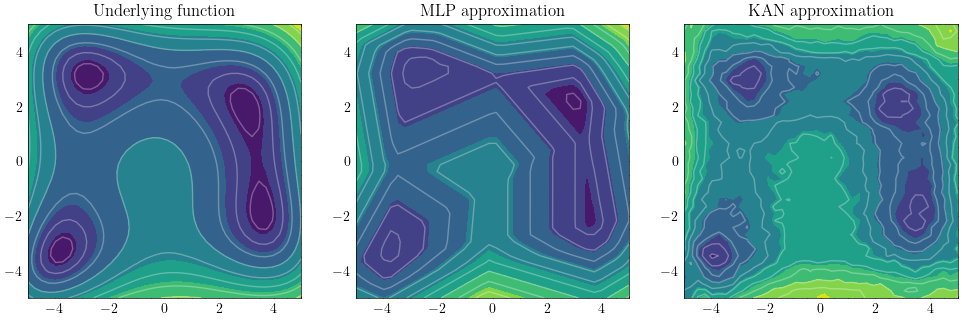

In [12]:
fig, ax = plt.subplots(ncols=3, figsize=(12, 6))
ax[0].set_box_aspect(1)
ax[1].set_box_aspect(1)
ax[2].set_box_aspect(1)

ax[0].contourf(x1, x2, y.reshape(samples, samples))
ax[0].contour(x1, x2, y.reshape(samples, samples), levels=10, colors="white", alpha=.3)
ax[0].set_title("Underlying function")

ax[1].contourf(x1, x2, y_pred_mlp.reshape(samples, samples))
ax[1].contour(x1, x2, y_pred_mlp.reshape(samples, samples), levels=10, colors="white", alpha=.3)
ax[1].set_title("MLP approximation")

ax[2].contourf(x1, x2, mu_full.reshape(samples, samples))
ax[2].contour(x1, x2, mu_full.reshape(samples, samples), levels=10, colors="white", alpha=.3)
ax[2].set_title("KAN approximation")

# TODO: Shared colorbar between the three plots!!! 

# cbar_max = jnp.max(jnp.max(y), jnp.max(y_pred_mlp), jnp.max(mu_full))
# cbar_min = jnp.min(jnp.min(y), jnp.min(y_pred_mlp), jnp.min(mu_full))
# norm = plt.Normalize(cbar_min, cbar_max)

# sm = ScalarMappable(cmap="jet", norm=norm)
# sm.set_array([])  # Empty array - using the norm instead
# cbar_row = fig.colorbar(sm, ax=[ax[0], ax[1], ax[2]], location='right', shrink=0.98, extend="max")
# cbar_row.set_label('Relative Error (\%)')
# ticks2 = np.arange(0, cbar_max + 1, 10)
# cbar_max.set_ticks(ticks2)
# cbar_row.set_ticklabels([f"{tick}" for tick in ticks2])
plt.show()


In [11]:
def rmse(y_true, y_pred):
    return jnp.sqrt(jnp.mean((y_true - y_pred) ** 2))
print(f"MLP RMSE: {rmse(y.flatten(), y_pred_mlp.flatten()):.3f}")
print(f"KAN RMSE: {rmse(y.flatten(), mu_full.flatten()):.3f}")

MLP RMSE: 0.941
KAN RMSE: 1.090
